## Sentiment Analysis Using RoBERTa

**Why I Shifted From BERT to DistilBERT and Finally RoBERTa**
 
 During this sentiment analysis project, I encountered various challenges that led me to switch models:

**What is DistilBERT?**
- DistilBERT (Developed by Hugging Face) is a lighter and faster version of BERT.
- It is trained using knowledge distillation, meaning it retains 97% of BERT’s accuracy while being 60% smaller and twice as fast.
- Full BERT was processing too slow for sentiment analysis on the dataset, so I switched to DistilBERT for faster processing.

**What is RoBERTa?**
- RoBERTa (Robustly Optimized BERT Pretraining Approach) was developed by Facebook AI as an improvement over BERT.
- It is trained on much more data than BERT and performs better on text classification tasks.
- The Twitter RoBERTa model (cardiffnlp/twitter-roberta-base-sentiment) is specifically fine-tuned for Twitter data, making it ideal for our analysis.
- DistilBERT only supported binary sentiment (Positive/Negative), but we needed a model that could detect Neutral sentiment as well. RoBERTa provides  three sentiment classes (Negative, Neutral, Positive), making it the best choice.

## Importing Libraries

In [2]:
!pip install torch torchvision torchaudio transformers nltk pandas

import pandas as pd  # Handling datasets
import torch  # PyTorch for deep learning computations
from transformers import BertTokenizer, BertForSequenceClassification  # BERT model & tokenizer
import nltk  # Natural Language Toolkit for text preprocessing
import re  # Regular expressions for text cleaning
from torch.utils.data import DataLoader, Dataset
import numpy as np  # Numerical operations

# Download necessary NLTK resources for text preprocessing
nltk.download('stopwords')
nltk.download('punkt')

# Check if CUDA (GPU) is available for faster processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


[nltk_data] Downloading package stopwords to C:\Users\Kaanchi
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Kaanchi
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing Data and Viewing the Data

In [4]:
# Load the datasets
trump_df = pd.read_csv(r"C:\Users\Kaanchi Gupta\Downloads\trump.csv")
harris_df = pd.read_csv(r"C:\Users\Kaanchi Gupta\Downloads\harris.csv")

# Preview the first few rows
print("Trump Dataset Sample:")
display(trump_df.head())


print("Harris Dataset Sample:")
display(harris_df.head())


Trump Dataset Sample:


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,831683895234007040,1833354711484739688,RT @KamalaHQ: Trump is going to lie at the deb...,2024-09-10 03:59:59+00:00,14181,0,0,0,NaN
1,899321381258539009,1833354711446999516,"RT @szaevermore: for taylor swift, talking abo...",2024-09-10 03:59:59+00:00,17431,0,0,0,NaN
2,720857191,1833354711438618816,RT @kylegriffin1: Breaking: Trump bragged to B...,2024-09-10 03:59:59+00:00,23285,0,0,0,NaN
3,1319754515524931584,1833354711426302274,RT @BoLoudon: WOW! If you love animals like I ...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1248617214468476928,1833354711346323915,RT @isthisnour: the fact that she’s made a who...,2024-09-10 03:59:59+00:00,9369,0,0,0,NaN


Harris Dataset Sample:


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,1673887475880845314,1833354711572856932,RT @bennyjohnson: Kamala openly brags about du...,2024-09-10 03:59:59+00:00,18287,0,0,0,NaN
1,23897765,1833354711560339900,RT @KnowaWasTaken: WBNA Super-Star Brittney Gr...,2024-09-10 03:59:59+00:00,1980,0,0,0,NaN
2,1055753008129196033,1833354711489032339,RT @JamesOKeefeIII: BREAKING: Google Growth St...,2024-09-10 03:59:59+00:00,22300,0,0,0,NaN
3,1319754515524931584,1833354711426302274,RT @BoLoudon: WOW! If you love animals like I ...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1183192509578502144,1833354711262470326,RT @EricLDaugh: 🚨 PREDICTIT HAS FLIPPED FOR TR...,2024-09-10 03:59:59+00:00,219,0,0,0,NaN


## Data Cleaning and Processing

**Emoji to Text** BERT does not understand emojis directly, so we convert them to text descriptions.

In [7]:
import emoji

def convert_emojis_to_text(text):
    """Replaces emojis with text descriptions."""
    return emoji.demojize(text, delimiters=(" ", " "))  # Converts 😂 → ":face_with_tears_of_joy:"

# Apply to Trump & Harris tweets
trump_df["Tweet"] = trump_df["Tweet"].apply(convert_emojis_to_text)
harris_df["Tweet"] = harris_df["Tweet"].apply(convert_emojis_to_text)

**Remove Hashtag-Only Tweets** Tweets containing only hashtags (e.g., #Trump #MAGA #2024) do not provide sentiment.

In [9]:
import re

def is_hashtag_only(text):
    """Returns True if a tweet contains only hashtags."""
    words = text.split()
    return all(word.startswith("#") for word in words)

# Apply function to remove hashtag-only tweets
trump_df = trump_df[~trump_df["Tweet"].apply(is_hashtag_only)]
harris_df = harris_df[~harris_df["Tweet"].apply(is_hashtag_only)]


**Remove or Modify Retweets** 
- Remove RT @username:" but keep the original tweet. 
- Remove duplicate retweets (if the same tweet appears multiple times)

In [11]:
import re

def remove_retweet_prefix(text):
    """Removes 'RT @username' from tweets while keeping original content."""
    return re.sub(r"RT @\w+: ", "", text)  # Removes the retweet header but keeps the tweet text

# Apply function
trump_df["Tweet"] = trump_df["Tweet"].apply(remove_retweet_prefix)
harris_df["Tweet"] = harris_df["Tweet"].apply(remove_retweet_prefix)

# Remove duplicate tweets (full duplicate content)
trump_df = trump_df.drop_duplicates(subset=["Tweet"])
harris_df = harris_df.drop_duplicates(subset=["Tweet"])


**Remove or Modify Tweet Replies** 
- Some replies only mention other users without adding new sentiment (e.g., @user Yes! 😂🔥).
- However, if the reply contains an opinion, we should keep it.
- The goal is to remove tweets that are just mentions and keep meaningful replies.

In [13]:
import re

def is_reply_only(text):
    """Detects if a tweet is just a reply (only mentions someone)."""
    return bool(re.fullmatch(r"@\w+", text))  # If tweet is only "@username", remove it

# Remove reply-only tweets
trump_df = trump_df[~trump_df["Tweet"].apply(is_reply_only)]
harris_df = harris_df[~harris_df["Tweet"].apply(is_reply_only)]


**Removing Stopwords**
- Stopwords are common words (e.g., "the", "is", "and", "of") that do not add sentiment but take up space.
- Use NLTK’s stopword list to filter out common words.
- Tokenize each tweet, remove stopwords, and reconstruct the cleaned text.

In [15]:
import nltk

# Download stopwords 
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Removes common English stopwords using simple split() instead of word_tokenize()."""
    words = text.split()  # Splits by spaces instead of tokenizing
    return " ".join([word for word in words if word.lower() not in stop_words])

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(remove_stopwords)
harris_df["Tweet"] = harris_df["Tweet"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to C:\Users\Kaanchi
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Kaanchi
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Expanding Contractions (e.g., "can't" → "cannot")** BERT and NLP models understand full words better than contractions.

In [17]:
!pip install contractions

import contractions

def expand_contractions(text):
    """Expands contractions like 'can't' → 'cannot'."""
    return contractions.fix(text)

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(expand_contractions)
harris_df["Tweet"] = harris_df["Tweet"].apply(expand_contractions)


**Removing Clickbait Words (e.g., "BREAKING", "SHOCKING")**
- Clickbait words like "BREAKING", "SHOCKING", "MUST WATCH" introduce bias and exaggeration.
- These phrases do not contribute to genuine sentiment but instead sensationalize content.
- Create a list of common clickbait phrases.
- Remove these words from tweets to reduce bias.

In [19]:
import re

clickbait_words = [
    "breaking", "shocking", "must read", "watch this", "click here",
    "this will surprise you", "you won’t believe", "viral", "shocking truth",
    "exclusive", "just in", "alert", "must watch", "you need to see this"
]

def remove_clickbait(text):
    """Removes common clickbait words from tweets, case insensitive."""
    words = text.split()  # Split text into words
    filtered_words = [word for word in words if word.lower().strip(".,:!?'\"") not in clickbait_words]  # Remove case variations & punctuation
    return " ".join(filtered_words)  # Join words back into a sentence

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(remove_clickbait)
harris_df["Tweet"] = harris_df["Tweet"].apply(remove_clickbait)

**Language Translation using Google Translate API**
- We use the googletrans library to automatically translate non-English tweets into English.
- If a tweet is already in English, it remains unchanged.

In [21]:
!pip install googletrans==4.0.0-rc1

from googletrans import Translator
from langdetect import detect, DetectorFactory
import langdetect

# Ensure consistent language detection
DetectorFactory.seed = 0  
translator = Translator()

def translate_to_english(text):
    """Detects language and translates non-English tweets to English."""
    try:
        lang = detect(text)  # Detect language
        if lang != "en":  # If not English, translate it
            translated = translator.translate(text, src=lang, dest="en")
            return translated.text
    except langdetect.lang_detect_exception.LangDetectException:
        return text  # If detection fails, keep the original text
    return text  # If already English, return as is

# Apply function to translate non-English tweets
trump_df["Tweet"] = trump_df["Tweet"].apply(translate_to_english)
harris_df["Tweet"] = harris_df["Tweet"].apply(translate_to_english)

**Removing URLs and Links** BERT and NLP models do not process URLs meaningfully, so removing them improves text clarity.

In [23]:
import re

def remove_urls(text):
    """Removes all URLs from tweets."""
    return re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Removes any URL starting with http, https, www


**Removing Special Characters, Numbers & Extra Spaces** Tweets often contain symbols, numbers, and unnecessary punctuation that do not contribute to sentiment.

In [25]:
import re

def clean_text(text):
    """Removes special characters, numbers, and extra spaces."""
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters and spaces
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(clean_text)
harris_df["Tweet"] = harris_df["Tweet"].apply(clean_text)

**Convert Tweets to Lowercase**

In [27]:
def to_lowercase(text):
    """Converts text to lowercase."""
    return text.lower()

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(to_lowercase)
harris_df["Tweet"] = harris_df["Tweet"].apply(to_lowercase)

**Removing Short or Meaningless Tweets**

In [29]:
def remove_short_tweets(text):
    """Removes tweets that have fewer than 3 words."""
    return len(text.split()) >= 3  # Keep tweets with 3 or more words

# Apply function to both datasets
trump_df = trump_df[trump_df["Tweet"].apply(remove_short_tweets)]
harris_df = harris_df[harris_df["Tweet"].apply(remove_short_tweets)]

**Final Text Cleaning - Stripping Extra Spaces**
- Some tweets may still have leading or trailing spaces due to previous cleaning steps.
- Ensuring tweets are properly formatted improves tokenization and model performance.

In [31]:
import re

def strip_extra_spaces(text):
    """Removes leading, trailing, and extra spaces between words."""
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    return text

# Apply function to both datasets
trump_df["Tweet"] = trump_df["Tweet"].apply(strip_extra_spaces)
harris_df["Tweet"] = harris_df["Tweet"].apply(strip_extra_spaces)

# Display updated DataFrames
display(trump_df.head())
display(harris_df.head())


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,831683895234007040,1833354711484739688,trump going lie debate lot biggest trump lies ...,2024-09-10 03:59:59+00:00,14181,0,0,0,NaN
1,899321381258539009,1833354711446999516,taylor swift talking palestine controversial h...,2024-09-10 03:59:59+00:00,17431,0,0,0,NaN
2,720857191,1833354711438618816,trump bragged bob woodward protected saudi ara...,2024-09-10 03:59:59+00:00,23285,0,0,0,NaN
3,1319754515524931584,1833354711426302274,wow love animals like do must vote rightful pr...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1248617214468476928,1833354711346323915,fact she is made whole thing antitrump release...,2024-09-10 03:59:59+00:00,9369,0,0,0,NaN


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source
0,1673887475880845314,1833354711572856932,kamala openly brags dumping haitian migrants a...,2024-09-10 03:59:59+00:00,18287,0,0,0,NaN
1,23897765,1833354711560339900,wbna superstar brittney griner wore kamala har...,2024-09-10 03:59:59+00:00,1980,0,0,0,NaN
2,1055753008129196033,1833354711489032339,google growth strategist exposes googles searc...,2024-09-10 03:59:59+00:00,22300,0,0,0,NaN
3,1319754515524931584,1833354711426302274,wow love animals like do must vote rightful pr...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN
4,1183192509578502144,1833354711262470326,policecarlight predictit flipped trump harris ...,2024-09-10 03:59:59+00:00,219,0,0,0,NaN


## BERT Analysis (RoBERTa)

**Step 1: Load Pre-Trained RoBERTa Sentiment Model**

In [78]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}



config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\Kaanchi Gupta\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kaanchi Gupta\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

**Step 2: Tokenizing Tweets for BERT Sentiment Analysis** 

In [81]:
def tokenize_tweets(tweets):
    """Tokenizes tweets for RoBERTa input format."""
    encoding = tokenizer(
        tweets.tolist(),  
        padding=True,    
        truncation=True,   
        max_length=64,  
        return_tensors="pt"
    )
    
    return encoding


**Running Tweets Through RoBERTa for Sentiment Analysis**

In [87]:
import torch.nn.functional as F
import numpy as np

batch_size = 512  # Process in batches for efficiency

def predict_sentiment_in_batches(df):
    """Runs tweets through RoBERTa in batches for sentiment analysis."""
    sentiments = []
    
    for i in range(0, len(df), batch_size):
        batch_tweets = df["Tweet"][i:i+batch_size]  # Get batch of tweets
        encodings = tokenize_tweets(batch_tweets)  # Tokenize batch

        # Move tokenized inputs to GPU (if available)
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)

        with torch.no_grad():  
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits  
        probs = F.softmax(logits, dim=-1)  
        predictions = torch.argmax(probs, dim=-1).cpu().numpy()  

        sentiments.extend(predictions)  

        torch.cuda.empty_cache()  # Free up GPU memory

    return np.array(sentiments)

# Apply batch prediction on both datasets
trump_df["Sentiment"] = predict_sentiment_in_batches(trump_df)
harris_df["Sentiment"] = predict_sentiment_in_batches(harris_df)

 

**Mapping Sentiment Scores to Labels**

In [89]:
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Apply correct sentiment labels
trump_df["Sentiment_Label"] = trump_df["Sentiment"].map(sentiment_labels)
harris_df["Sentiment_Label"] = harris_df["Sentiment"].map(sentiment_labels)

# Display updated DataFrames
display(trump_df.head())
display(harris_df.head())



,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source,Sentiment,Sentiment_Label
0,831683895234007040,1833354711484739688,trump going lie debate lot biggest trump lies ...,2024-09-10 03:59:59+00:00,14181,0,0,0,NaN,0,Negative
1,899321381258539009,1833354711446999516,taylor swift talking palestine controversial h...,2024-09-10 03:59:59+00:00,17431,0,0,0,NaN,0,Negative
2,720857191,1833354711438618816,trump bragged bob woodward protected saudi ara...,2024-09-10 03:59:59+00:00,23285,0,0,0,NaN,1,Neutral
3,1319754515524931584,1833354711426302274,wow love animals like do must vote rightful pr...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN,2,Positive
4,1248617214468476928,1833354711346323915,fact she is made whole thing antitrump release...,2024-09-10 03:59:59+00:00,9369,0,0,0,NaN,1,Neutral


,User ID,Tweet ID,Tweet,Created at,Retweets,Replies,Likes,Quotes,Source,Sentiment,Sentiment_Label
0,1673887475880845314,1833354711572856932,kamala openly brags dumping haitian migrants a...,2024-09-10 03:59:59+00:00,18287,0,0,0,NaN,0,Negative
1,23897765,1833354711560339900,wbna superstar brittney griner wore kamala har...,2024-09-10 03:59:59+00:00,1980,0,0,0,NaN,1,Neutral
2,1055753008129196033,1833354711489032339,google growth strategist exposes googles searc...,2024-09-10 03:59:59+00:00,22300,0,0,0,NaN,1,Neutral
3,1319754515524931584,1833354711426302274,wow love animals like do must vote rightful pr...,2024-09-10 03:59:59+00:00,363,0,0,0,NaN,2,Positive
4,1183192509578502144,1833354711262470326,policecarlight predictit flipped trump harris ...,2024-09-10 03:59:59+00:00,219,0,0,0,NaN,1,Neutral


**Visualizing Sentiment Trends**

                 Trump Tweets  Harris Tweets
Sentiment_Label                             
Negative                  433            350
Neutral                   539            583
Positive                   65             55


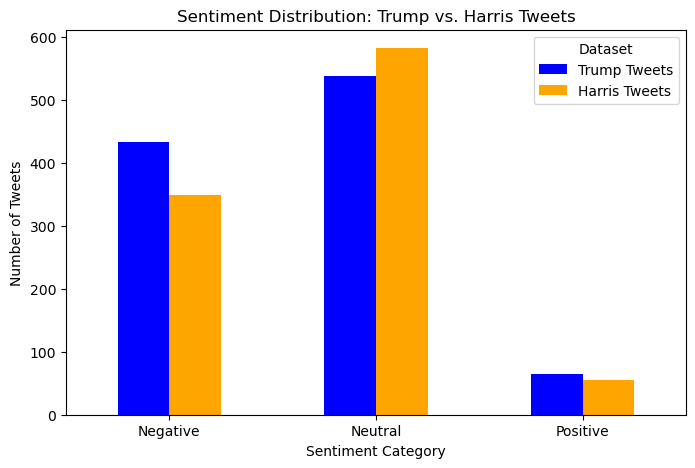

In [104]:
# Calculate sentiment distribution for both datasets
trump_sentiment_counts = trump_df["Sentiment_Label"].value_counts().sort_index()
harris_sentiment_counts = harris_df["Sentiment_Label"].value_counts().sort_index()

# Create a DataFrame for comparison
sentiment_comparison_df = pd.DataFrame({
    "Trump Tweets": trump_sentiment_counts,
    "Harris Tweets": harris_sentiment_counts
}).fillna(0)  # Fill NaN values with 0 if any category is missing

# Display the sentiment distribution table
print(sentiment_comparison_df)

# Plot the sentiment distribution comparison
sentiment_comparison_df.plot(kind="bar", figsize=(8,5), color=["blue", "orange"])
plt.title("Sentiment Distribution: Trump vs. Harris Tweets")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.legend(title="Dataset")
plt.show()



**Individual Compostion of Tweets**

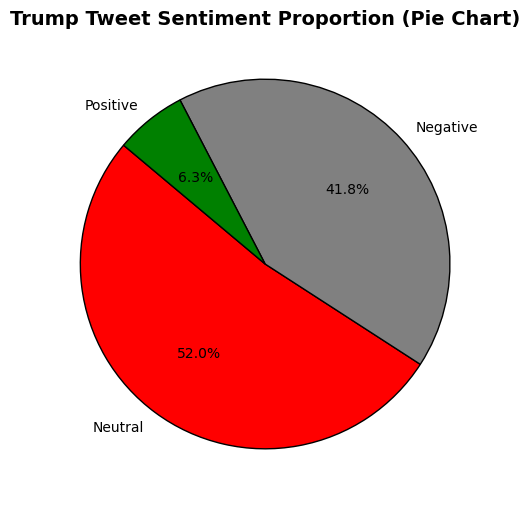

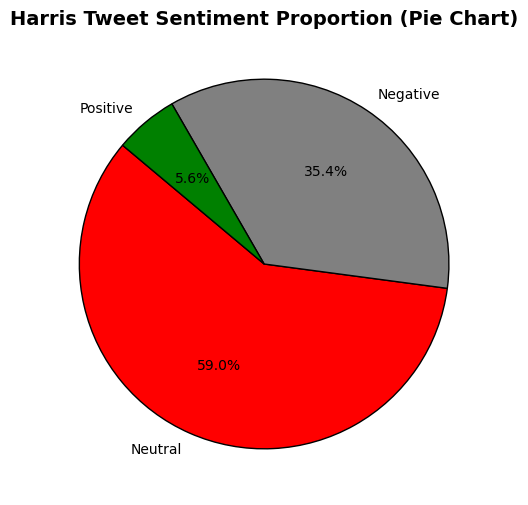

In [144]:
def plot_sentiment_pie(df, title):
    """Plots a pie chart for sentiment proportions."""
    sentiment_counts = df["Sentiment_Label"].value_counts()

    plt.figure(figsize=(6,6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", 
            colors=["red", "gray", "green"], startangle=140, wedgeprops={"edgecolor": "black"})

    plt.title(title, fontsize=14, fontweight="bold")
    plt.show()

# Plot sentiment proportions as pie charts
plot_sentiment_pie(trump_df, "Trump Tweet Sentiment Proportion (Pie Chart)")
plot_sentiment_pie(harris_df, "Harris Tweet Sentiment Proportion (Pie Chart)")



## Key Insights From the Visualizations ##

**Combined Sentiment Distribution (Bar Chart)**
- Trump-related tweets had a higher proportion of Negative sentiment than Harris-related tweets.
- Harris-related tweets had a slightly higher proportion of Neutral sentiment.
- Both datasets had very low Positive sentiment, reinforcing that discussions about both figures were either Neutral or Negative.

**Individual Pie-Charts**
- Neutral sentiment dominates both Trump (52.0%) and Harris (59.0%) tweets, showing most discussions are objective or non-opinionated.
- Trump tweets have more negativity (41.8%) than Harris (35.4%), suggesting he faces more criticism.
- Positive sentiment is very low for both (Trump: 6.3%, Harris: 5.6%), indicating limited supportive engagement.
- Harris-related tweets lean more neutral, while Trump has a stronger divide between neutral and negative sentiments.


## Final Conclusion ##

- Public sentiment on Twitter towards both Trump and Harris skews towards Neutral and Negative.
- Using RoBERTa was essential to capture Neutral sentiment, making the analysis more accurate.
- The low percentage of Positive sentiment suggests that political discussions on Twitter tend to be more critical or indifferent rather than supportive.
- Further analysis could explore which topics drive negativity in tweets about Trump and Harris.